### Segmentation backbone의 결과 T-SNE 시각화

In [1]:
! pip install segmentation_models_pytorch

  Using cached Pillow-9.4.0-cp39-cp39-manylinux_2_28_x86_64.whl (3.4 MB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.3.2
    Uninstalling Pillow-8.3.2:
      Successfully uninstalled Pillow-8.3.2


In [2]:
! pip install -U albumentations

In [3]:
import sys
sys.path.append('../')

In [4]:
import os, glob, random, cv2
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import albumentations as A
import segmentation_models_pytorch as smp

from albumentations.pytorch import transforms
from pathlib import Path

from link_ver3.segmentation.data_loader.dataloader import get_dataloader

In [5]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [6]:
import torchvision
import matplotlib.pyplot as plt
from PIL import Image

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

batch_size = 8
damage = 'scratch'

root_dir = '/aiffel/aiffel/4. Aiffelthon/socar_damaged/accida_segmentation_dataset_v1/'
train_dir = root_dir + f'{damage}/train/'
val_dir = root_dir + f'/{damage}/valid/'
test_dir = root_dir + f'/{damage}/test/'

mean= (0.5, 0.5, 0.5)
std= (0.5, 0.5, 0.5)
image_size = 512

In [8]:
transform_train = A.Compose([
    A.Resize(image_size, image_size),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    A.Rotate((-10, 10), p=0.5, border_mode=cv2.BORDER_REFLECT,),
    A.Normalize(mean, std),
    transforms.ToTensorV2(transpose_mask=True)
])

transform_val = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize(mean, std),
    transforms.ToTensorV2(transpose_mask=True)
])

transform_test = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize(mean, std),
    transforms.ToTensorV2(transpose_mask=True)
])

In [9]:
train_dataloader = get_dataloader(train_dir, transform_train, batch_size, True)
val_dataloader = get_dataloader(val_dir, transform_val, batch_size, False)
test_dataloader = get_dataloader(test_dir, transform_test, batch_size, False)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = smp.Unet(encoder_name='efficientnet-b0', encoder_weights='imagenet', in_channels=3, classes=1, activation=None)

In [11]:
encoder = nn.Sequential(*list(list(model.encoder.children())[:2] + list(list(model.encoder.children())[2].children()) + list(model.encoder.children())[3:]))

In [12]:
val_dataloader.__len__()

33

In [13]:
labels_list = []
for idx, data in enumerate(val_dataloader):
    label_list2 = []
    labels = data['label']
    for label in labels:
        if (label == 0).all():
            label_list2.append(0)
        else:
            label_list2.append(1)
    labels_list.append(label_list2)

In [14]:
labels_list.__len__()

33

In [15]:
from tqdm import tqdm
import time

out_list = []

for data in test_dataloader:
    input_tensor = data['input']
    if torch.cuda.is_available():
        model = model.cuda()
        input_tensor = input_tensor.cuda()
        output = nn.Sequential(*list(list(model.encoder.children())[:2] + list(list(model.encoder.children())[2].children()) + list(model.encoder.children())[3:] ))(input_tensor).squeeze()
    out_list.append(output.cpu().detach().numpy())

In [16]:
out_tensor = torch.from_numpy(np.array(out_list))
out_tensor.shape

torch.Size([33, 8, 1280])

In [17]:
out_tensor = out_tensor.view(-1,1280)

In [18]:
out_tensor.shape

torch.Size([264, 1280])

In [20]:
labels_list = torch.tensor(labels_list).view(-1).squeeze()

In [21]:
out_tensor.shape, labels_list.shape

(torch.Size([264, 1280]), torch.Size([264]))

In [22]:
from sklearn.manifold import TSNE

n_componenets = 2
tsne = TSNE(n_components=n_componenets, perplexity=40)

In [23]:
cluster = np.array(tsne.fit_transform(np.array(out_tensor)))

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [24]:
actual = np.array(labels_list)

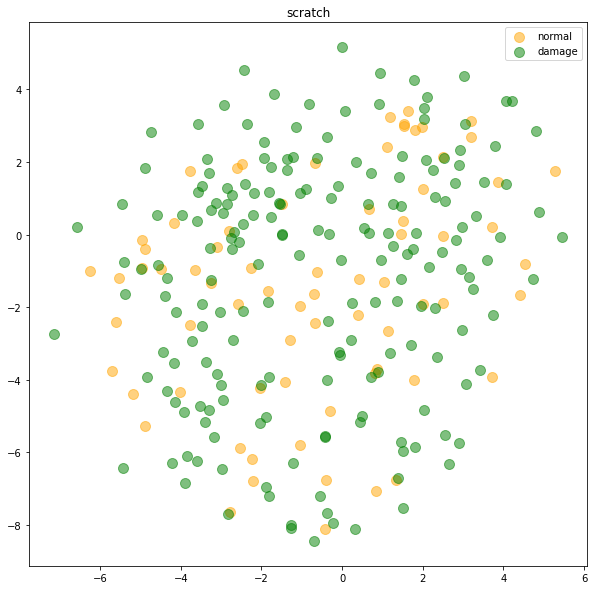

In [28]:
plt.figure(figsize=(10, 10))

damage_= ['normal', 'damage']
# marker = ['o', '^', 's']
color = ['orange', 'green', 'purple']

for i, label in zip(range(2), damage_):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], label=label, color=color[i], s=100, alpha=0.5) # marker=marker[i]
    
plt.title(f'{damage}')
# plt.xlim([-8, 8])
# plt.ylim([-8, 8])
plt.legend()
# plt.savefig(f'./T-SNE/encoder_{damage}.png', dpi=300)